<a href="https://colab.research.google.com/github/yzbaya/FAD.Machine-Learning/blob/main/FAD_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [33]:
data = pd.read_csv('histoFAD.csv', encoding='latin1')

<ipython-input-33-a38ad0390545>:1: DtypeWarning: Columns (5,14,22,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('histoFAD.csv', encoding='latin1')


**Préparation des Données **

**numeric data**

In [34]:
numeric_features = ['NJR','CMJ']
print(data[numeric_features].dtypes)
#extract et imputer les colonnes numeriques
numeric_features = ['NJR','CMJ']
imputer_numeric=SimpleImputer(strategy='median')
data[numeric_features]=imputer_numeric.fit_transform(data[numeric_features])

NJR      int64
CMJ    float64
dtype: object


In [35]:
# Nettoyer et traiter les caractéristiques de type date
date_columns = ['DDA', 'DDV']
reference_date = pd.to_datetime('2024-01-01')
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
    data[col] = (reference_date - data[col]).dt.days

# Imputer les valeurs manquantes pour les dates
imputer = SimpleImputer(strategy='median')
data[date_columns] = imputer.fit_transform(data[date_columns])

In [36]:
# List des colonnes à convertir et à imputer
columns_to_convert = ['Vente 2024','Vente 2022','Vente 2023','Ecoulement','DDA','DDV','Stocks','Prix unitaire']
# print('autres colonnes')
# print(data[columns_to_convert].dtypes)
def convert_data(data,columns_to_convert):
    for column in columns_to_convert:
        data[column] = data[column].replace({',': '.'}, regex=True)  # Remplacer les virgules par des points
        data[column] = pd.to_numeric(data[column], errors='coerce')  # Convertir en numérique
        imputer_cols = SimpleImputer(strategy='median')
        data[column] = imputer_cols.fit_transform(data[[column]])  # Imputer les valeurs manquantes
        # data[column] = pd.Series(data[column].flatten()).apply(lambda x: max(x, 0))  # Remplacer les valeurs négatives par zéro
    return data


data=convert_data(data,columns_to_convert)
#test
print('colonnes non num')
print(data[columns_to_convert].dtypes)

print("Vérification générale des valeurs manquantes:")
print(data[columns_to_convert].isna().sum())
print(data[numeric_features].isna().sum())

colonnes non num
Vente 2024       float64
Vente 2022       float64
Vente 2023       float64
Ecoulement       float64
DDA              float64
DDV              float64
Stocks           float64
Prix unitaire    float64
dtype: object
Vérification générale des valeurs manquantes:
Vente 2024       0
Vente 2022       0
Vente 2023       0
Ecoulement       0
DDA              0
DDV              0
Stocks           0
Prix unitaire    0
dtype: int64
NJR    0
CMJ    0
dtype: int64


**categorical data**

In [37]:
# Sélection et imputation des données catégorielles
categorical_features = ['Pareto']
imputer_mostfrequent = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer_mostfrequent.fit_transform(data[categorical_features])
print(data[categorical_features].isna().sum())

data['Pareto_copy'] = data['Pareto']
# Mapping importance des pièces
pareto_importance = {
    'AA': 1, 'AB': 2, 'AC': 3, 'AD': 4,
    'BA': 5, 'BB': 6, 'BC': 7, 'BD': 8,
    'CA': 9, 'CB': 10, 'CC': 11, 'CD': 12,
    'DA': 13, 'DB': 14, 'DC': 15, 'DD': 16
}
data['Importance'] = data['Pareto_copy'].map(pareto_importance)

# Encodage one-hot
data = pd.get_dummies(data, columns=['Pareto_copy'], prefix='Pareto')


# Afficher les premières lignes du dataframe pour une vérification visuelle
print(data.head())


Pareto    0
dtype: int64
           N°                                        Désignation  \
0  EFM1300113  JAUGE + POMPE DIESEL-A2124700194-MERCEDES S212...   
1       01090         PARAH.ROUE  068198171 11*85*105  AD 80-100   
2       01110                       SUPPORT BV -811399151A- AD80   
3       02113  BOUCHON CACHE SOUPAPE -06B103485C- GOLF 5-6/PO...   
4       02234               ROTULE DIRECTION -861419812- AUDI 80   

  Plage de Stock Enseigne  Stocks Qté sur commande vente S-CVTE  \
0            VIF     ACHR     1.0                     0.   1.00   
1            VIF     FEBI    44.0                     0.  44.00   
2           LENT     FEBI    21.0                     0.  21.00   
3            VIF     FEBI    41.0                     0.  41.00   
4            VIF     FEBI     0.0                     0.   0.00   

   Prix unitaire Coût unitaire  Vente 2022  ...  Pareto_BA  Pareto_BB  \
0         219.98       135.296     418.282  ...      False      False   
1          24.83 

normalisation of data

In [38]:
#Normalisation des donées
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_scale = ['Vente 2024','Vente 2022','Vente 2023','Ecoulement','DDA','DDV','Stocks','Prix unitaire']
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [39]:

from sklearn.model_selection import train_test_split
features = ['NJR', 'CMJ', 'Vente 2022', 'Vente 2023', 'Ecoulement', 'Importance','DDA','DDV','Stocks','Prix unitaire'] + [col for col in data.columns if col.startswith('Pareto_')]
X=data[features]
y=data['Vente 2024']
# Vérifier à nouveau les valeurs manquantes dans y
print("Vérification des valeurs manquantes dans y après suppression des lignes:")
print(data['Vente 2024'].isna().sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Vérification des valeurs manquantes dans y après suppression des lignes:
0


Régression Linéaire - MAE: 0.09967873021616411, MSE: 0.020683854119923337
Random Forest - MAE: 0.0763645188486243, MSE: 0.014769114093415988
Comparaison des Modèles:
Régression Linéaire - MAE: 0.09967873021616411, MSE: 0.020683854119923337
Random Forest - MAE: 0.0763645188486243, MSE: 0.014769114093415988


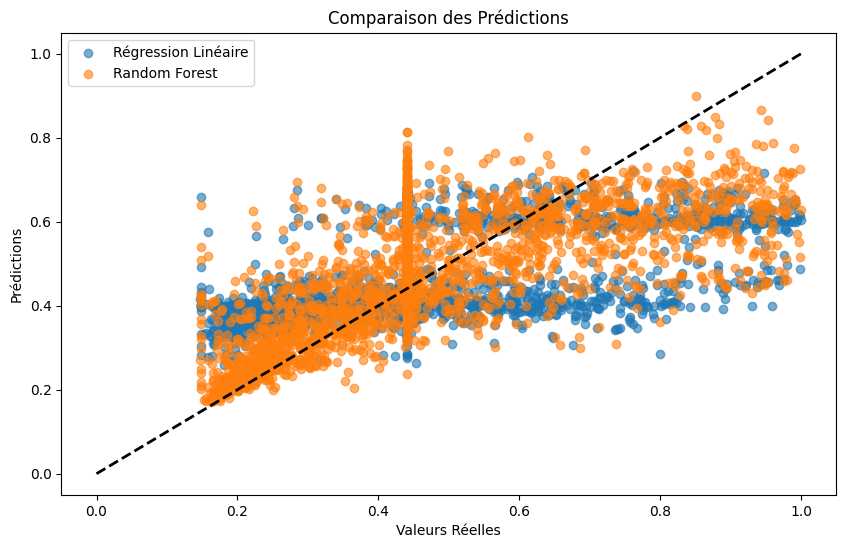

In [40]:
# # Entraîner le modèle de régression linéaire
# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)

# # Prédictions et évaluation pour la régression linéaire
# y_pred_lin = lin_reg.predict(X_test)
# mae_lin = mean_absolute_error(y_test, y_pred_lin)
# mse_lin = mean_squared_error(y_test, y_pred_lin)
# print(f"Régression Linéaire - MAE: {mae_lin}, MSE: {mse_lin}")

# Entraîner le modèle de Random Forest
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Prédictions et évaluation pour Random Forest
y_pred_rf = rf_reg.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}")

# Comparer les modèles
print(f"Comparaison des Modèles:")
print(f"Régression Linéaire - MAE: {mae_lin}, MSE: {mse_lin}")
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}")

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lin, label='Régression Linéaire', alpha=0.6)
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend()
plt.title('Comparaison des Prédictions')
plt.show()

Random Forest - MAE: 0.0763645188486243, MSE: 0.014769114093415988


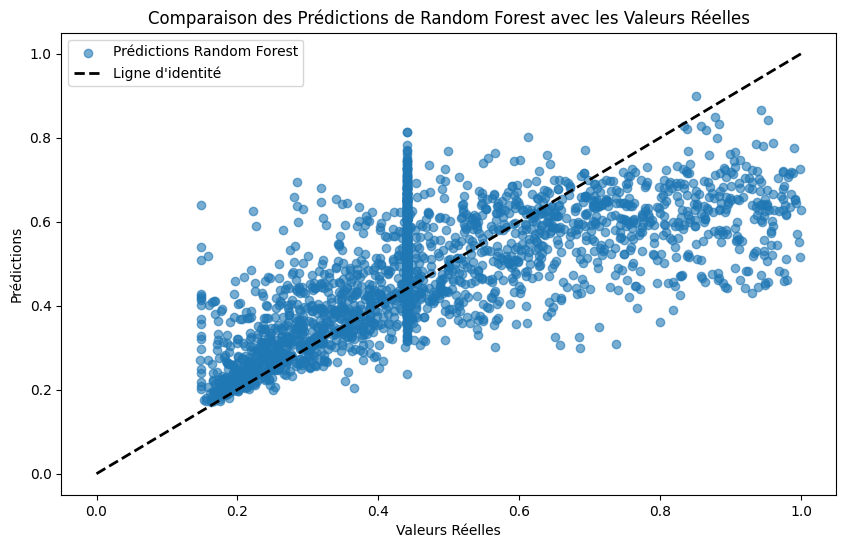

In [41]:
# Entraîner le modèle de Random Forest
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_rf = rf_reg.predict(X_test)

# Évaluer les prédictions
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}")

# Afficher les prédictions par rapport aux valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Prédictions Random Forest')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Ligne d\'identité')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des Prédictions de Random Forest avec les Valeurs Réelles')
plt.legend()
plt.show()


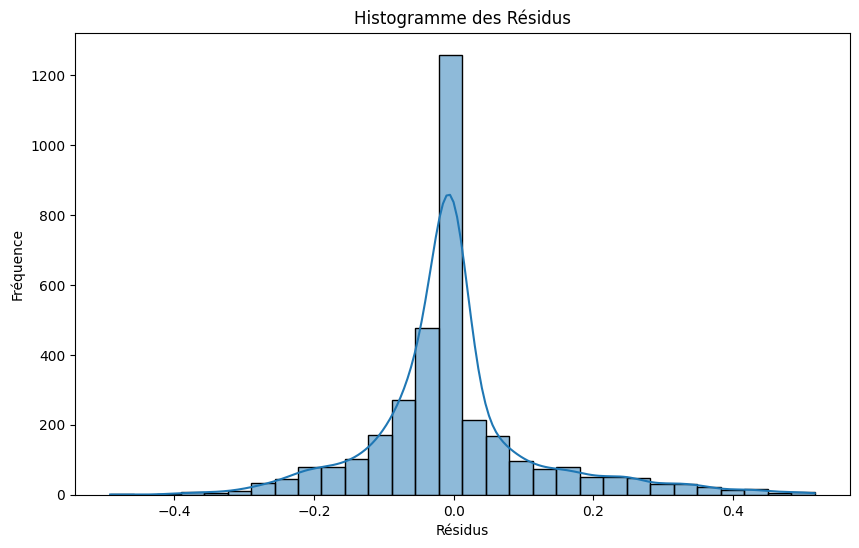

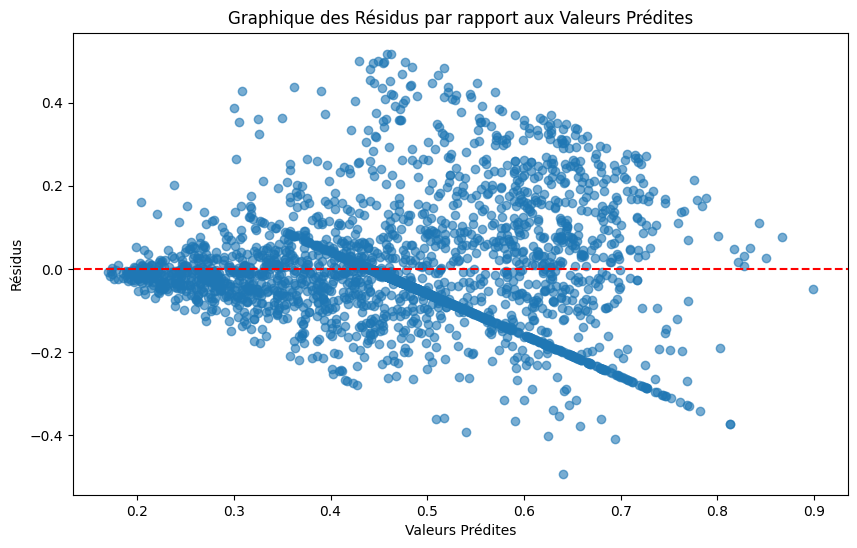

In [42]:
# Calculer les résidus
residuals = y_test - y_pred_rf

# Tracer un histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogramme des Résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

# Tracer les résidus par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Graphique des Résidus par rapport aux Valeurs Prédites')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.show()
